### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

#### Fonction d'evaluation selon les métrics demande

In [2]:
def evaluate_model(model, X_val: np.ndarray, y_val: np.ndarray):
    """Evaluate the model using specified metrics."""
    predictions = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y_val, predictions),
        "Precision": precision_score(y_val, predictions, zero_division=0),
        "Recall": recall_score(y_val, predictions, zero_division=0),
        "F1-score": f1_score(y_val, predictions, zero_division=0),
        "ROC-AUC": roc_auc_score(y_val, probs) if probs is not None else "N/A"
    }

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

#### class MLBO

In [3]:
class RandomForestOptimizer:
    def __init__(self, param_ranges):
        self.param_ranges = param_ranges

    def params_from_solution(self, solution: np.ndarray):
        params = {}
        for i, (param_name, (min_val, max_val)) in enumerate(self.param_ranges.items()):
            params[param_name] = int(solution[i] * (max_val - min_val) + min_val)
        return params

    def objective_function(self, solution: np.ndarray, X_train, y_train, X_val, y_val):
        model = RandomForestClassifier(**self.params_from_solution(solution))
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        return 1 - accuracy_score(y_val, predictions)

    def optimize(self, population: np.ndarray, X_train: np.ndarray, y_train: np.ndarray,
                X_val: np.ndarray, y_val: np.ndarray, iterations: int = 10) -> np.ndarray:
        print('Starting MLBO optimization..')
        population = population.copy()

        fitness = [self.objective_function(p, X_train, y_train, X_val, y_val) for p in population]
        leader = population[np.argmin(fitness)].copy()
        print(f'Initial leader fitness: {min(fitness):.4f}')

        best_fitness_history = []

        for iteration in range(iterations):
            print(f'Iteration {iteration + 1}/{iterations}...')
            new_leader = 0.5 * leader + 0.5 * population[np.random.randint(0, len(population))]

            for i in range(len(population)):
                distance = np.linalg.norm(population[i] - new_leader)
                step_size = distance / 2
                new_solution = population[i] + step_size * (new_leader - population[i])
                population[i] = np.clip(new_solution, 0, 1)

            fitness = [self.objective_function(p, X_train, y_train, X_val, y_val) for p in population]
            best_index = np.argmin(fitness)
            current_best_fitness = fitness[best_index]
            best_fitness_history.append(current_best_fitness)

            print(f'Best fitness in iteration {iteration + 1}: {current_best_fitness:.4f}')
            if current_best_fitness < self.objective_function(leader, X_train, y_train, X_val, y_val):
                leader = population[best_index].copy()

        # Plot optimization progress
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, iterations + 1), best_fitness_history, 'b-')
        plt.title('Optimization Progress')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness (1 - Accuracy)')
        plt.grid(True)
        plt.show()

        # Evaluate the leader solution
        best_params = self.params_from_solution(leader)
        best_model = RandomForestClassifier(**best_params)
        best_model.fit(X_train, y_train)
        print("\nOptimization Complete.")
        print("Best Parameters:", best_params)
        print("\nEvaluation Metrics:")
        evaluate_model(best_model, X_val, y_val)

        return population, best_model

#### main contenat le prepropcessing et l'appel des fonction

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model with default parameters
model = RandomForestClassifier()

# Print the default parameters of the model (before optimization)
print("Default Parameters initiation:", model.get_params())


Default Parameters (Before Optimization): {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-7524b44de093>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['Likes'].fillna(0, inplace=True)
<ipython-input-8-7524b44de093>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '


Selected features: Index(['Likes', 'Groups', 'Mutual Friends', 'Posts', 'Education_Not Exist',
       'Work_Not Exist', 'Living Place_Not Exist',
       'Relationship \ Family_Not Exist'],
      dtype='object')
Best Parameters before mlbo {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Starting MLBO optimization..
Initial leader fitness: 0.0201
Iteration 1/10...
Best fitness in iteration 1: 0.0201
Iteration 2/10...
Best fitness in iteration 2: 0.0201
Iteration 3/10...
Best fitness in iteration 3: 0.0201
Iteration 4/10...
Best fitness in iteration 4: 0.0201
Iteration 5/10...
Best fitness in iteration 5: 0.0201
Iteration 6/10...
Best fitness in iteration 6: 0.0201
Iteration 7/10...
Best fitness in iteration 7: 0.0201
Iteration 8/10...
Best fitness in iteration 8: 0.0201
Iteration 9/10...
Best fitness in iteration 9: 0.0201
Iteration 10/10...
Best fitness in iteration 10: 0.0201


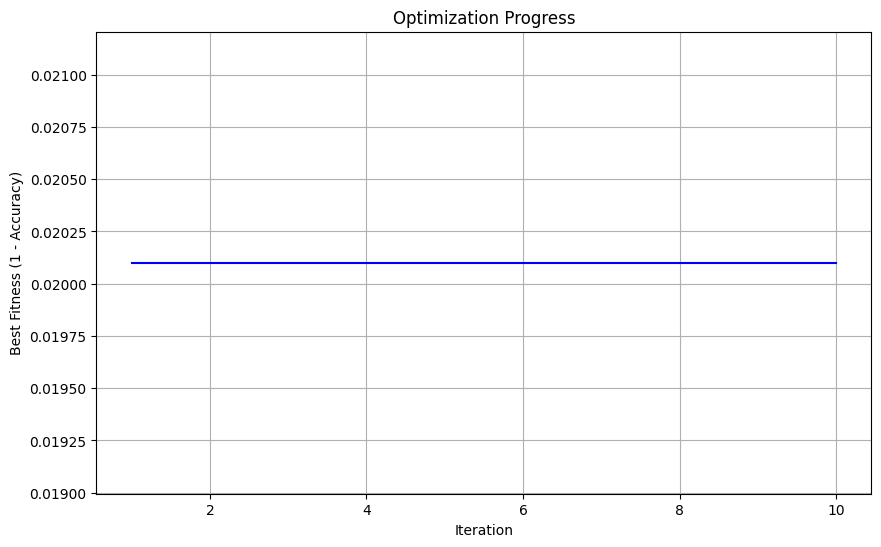


Optimization Complete.
Best Parameters: {'n_estimators': 109, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4}

Evaluation Metrics:
Accuracy: 0.9799
Precision: 0.9885
Recall: 0.9885
F1-score: 0.9885
ROC-AUC: 0.9945

Final Evaluation on Test Set:
Accuracy: 0.9839
Precision: 0.9906
Recall: 0.9906
F1-score: 0.9906
ROC-AUC: 0.9963


<Figure size 1000x600 with 0 Axes>

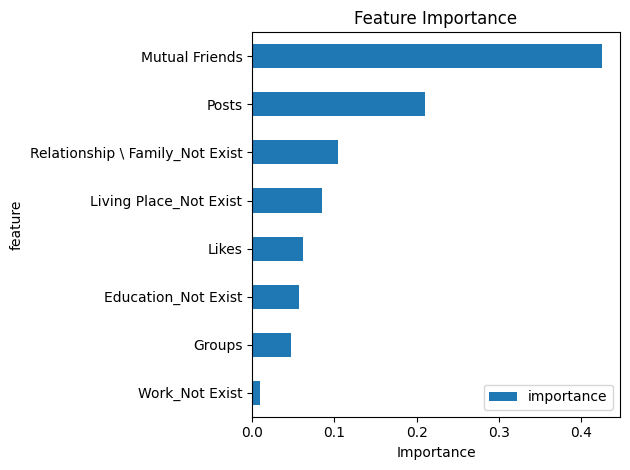

In [8]:
def main():
    from google.colab import drive
    drive.mount('/content/drive')

    # Load the data
    file_path = '/content/drive/My Drive/Facebook Dataset 9_9_2019.xlsx'
    data = pd.ExcelFile(file_path).parse('Sheet1')

    # Data cleaning and preprocessing
    data_cleaned = data.drop(columns=['Link'])

    # Handle missing values
    data_cleaned['Likes'].fillna(0, inplace=True)
    data_cleaned['Groups'].fillna(0, inplace=True)

    categorical_columns = ['Education', 'Work', 'Living Place', 'Relationship \\ Family', 'Intro.', 'CLASS']
    numeric_columns = ['Likes', 'Groups', 'Mutual Friends', 'Posts', 'Tags']

    for col in categorical_columns:
        data_cleaned[col].fillna('Unknown', inplace=True)

    # Create processed dataset
    data_processed = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

    # Convert remaining object columns to numeric
    for col in data_processed.select_dtypes(include=['object']).columns:
        data_processed[col] = pd.to_numeric(data_processed[col], errors='coerce')

    # Convert boolean columns to int
    data_processed = data_processed.astype({col: 'int' for col in data_processed.select_dtypes(include=['bool']).columns})

    # Standardize numeric columns
    scaler = StandardScaler()
    data_processed[numeric_columns] = scaler.fit_transform(data_processed[numeric_columns])

    # Prepare data for feature selection
    data_clean = data_processed.dropna(subset=['CLASS_Real'])
    X_clean = data_clean.drop('CLASS_Real', axis=1)
    columns_to_drop = ['Profile Picture', 'CheckIn', 'Name_id']
    X_clean = X_clean.drop(columns=[col for col in columns_to_drop if col in X_clean.columns])
    y_clean = data_clean['CLASS_Real']

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_clean)

    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=min(8, X_clean.shape[1]))
    X_new = selector.fit_transform(X_imputed, y_clean)
    selected_columns = X_clean.columns[selector.get_support()]
    print("\nSelected features:", selected_columns)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_clean, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Define parameter ranges for optimization
    param_ranges = {
        'n_estimators': (50, 200),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    }

    # Perform GridSearchCV for hyperparameter optimization
    grid_search = GridSearchCV(model, param_ranges, cv=3)
    grid_search.fit(X_train, y_train)  # Use your training data

    # Retrieve and print the best parameters after optimization
    best_params = grid_search.best_params_
    print("Best Parameters before mlbo", best_params)

    # Initialize optimizer
    optimizer = RandomForestOptimizer(param_ranges)

    # Generate initial population
    population_size = 20
    population = np.random.random((population_size, len(param_ranges)))

    # Run optimization
    final_population, best_model = optimizer.optimize(
        population=population,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        iterations=10
    )

    # Final evaluation on test set
    print("\nFinal Evaluation on Test Set:")
    evaluate_model(best_model, X_test, y_test)

    # Feature importance visualization
    feature_importance = pd.DataFrame({
        'feature': selected_columns,
        'importance': best_model.feature_importances_
    })

    plt.figure(figsize=(10, 6))
    feature_importance.sort_values('importance', ascending=True).plot(x='feature', y='importance', kind='barh')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()